In [28]:
holiday_col = "is_holiday_bcn" if "is_holiday_bcn" in df.columns else (
    "is_holiday_new" if "is_holiday_new" in df.columns else "is_holiday"
)
print("holiday_col usada:", holiday_col)
print(df[holiday_col].value_counts(dropna=False))


holiday_col usada: is_holiday_new
is_holiday_new
0    1000000
Name: count, dtype: int64


In [29]:
d0 = df.loc[df[holiday_col] == 0, "bikes_available_mean"].dropna()
d1 = df.loc[df[holiday_col] == 1, "bikes_available_mean"].dropna()

print("n no festivo:", len(d0), "| n festivo:", len(d1))

if len(d1) == 0:
    print("⚠️ Este sample no tiene festivos. Necesitas un sample dirigido o regenerarlo.")
else:
    plt.figure()
    plt.boxplot([d0, d1], labels=["no festivo", "festivo"], showfliers=False)
    plt.title(f"Bikes disponibles: festivo vs no festivo ({holiday_col})")
    plt.ylabel("bikes_available_mean")
    plt.show()


n no festivo: 1000000 | n festivo: 0
⚠️ Este sample no tiene festivos. Necesitas un sample dirigido o regenerarlo.


In [17]:
from pathlib import Path
import pandas as pd

# Intenta cargar pyarrow y si no está, te lo dirá claro
try:
    import pyarrow.parquet as pq
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "No tienes pyarrow en ESTE entorno del notebook.\n"
        "Solución: pip install pyarrow (en el mismo intérprete/kernel del notebook)."
    ) from e

import matplotlib.pyplot as plt

# Buscar raíz del proyecto subiendo carpetas hasta encontrar /data o /.git
ROOT = Path.cwd().resolve()
for _ in range(6):
    if (ROOT / "data").exists() or (ROOT / ".git").exists():
        break
    ROOT = ROOT.parent

print("ROOT =", ROOT)
print("CWD  =", Path.cwd().resolve())
print("data exists? =", (ROOT / "data").exists())

SAMPLE = ROOT / "data" / "gold" / "samples" / "bicing_gold_final_sample_1M.parquet"
print("SAMPLE =", SAMPLE)

df = pq.read_table(SAMPLE).to_pandas()

# Tipos
df["time_hour"] = pd.to_datetime(df["time_hour"], errors="coerce")
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("df.shape =", df.shape)
print("time_hour:", df["time_hour"].min(), "->", df["time_hour"].max())


ROOT = C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml
CWD  = C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\notebooks\eda
data exists? = True
SAMPLE = C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\data\gold\samples\bicing_gold_final_sample_1M.parquet
df.shape = (1000000, 21)
time_hour: 2019-03-28 18:00:00 -> 2025-12-31 23:00:00


In [18]:
dup_keys = df.duplicated(["station_id", "time_hour"]).sum()
print("dup_keys(sample) =", dup_keys)

nulls = df.isna().sum().sort_values(ascending=False)
print("\nTop 15 nulos:\n", nulls.head(15))


dup_keys(sample) = 0

Top 15 nulos:
 lag_24h_bikes           32449
lag_1h_bikes              103
bikes_available_mean        0
time_hour                   0
station_id                  0
mechanical_mean             0
docks_available_mean        0
ebike_mean                  0
obs_count                   0
month                       0
date                        0
hour                        0
dayofweek                   0
is_holiday                  0
is_weekend                  0
dtype: int64


In [19]:
# Ver qué columnas contienen "holiday"
holiday_cols = [c for c in df.columns if "holiday" in c.lower()]
print("holiday_cols =", holiday_cols)

# Preferencia:
# 1) is_holiday_bcn (si existe)
# 2) is_holiday (si existe)
# 3) la primera que contenga "holiday"
if "is_holiday_bcn" in df.columns:
    base_holiday_col = "is_holiday_bcn"
elif "is_holiday" in df.columns:
    base_holiday_col = "is_holiday"
elif len(holiday_cols) > 0:
    base_holiday_col = holiday_cols[0]
else:
    base_holiday_col = None

print("base_holiday_col =", base_holiday_col)

# Crear is_holiday_new (0/1) aunque venga con NaN o tipos raros
if base_holiday_col is None:
    df["is_holiday_new"] = 0
else:
    df["is_holiday_new"] = (
        pd.to_numeric(df[base_holiday_col], errors="coerce")
        .fillna(0)
        .astype(int)
        .clip(0, 1)
    )

print(df["is_holiday_new"].value_counts(dropna=False))


holiday_cols = ['is_holiday']
base_holiday_col = is_holiday
is_holiday_new
0    1000000
Name: count, dtype: int64


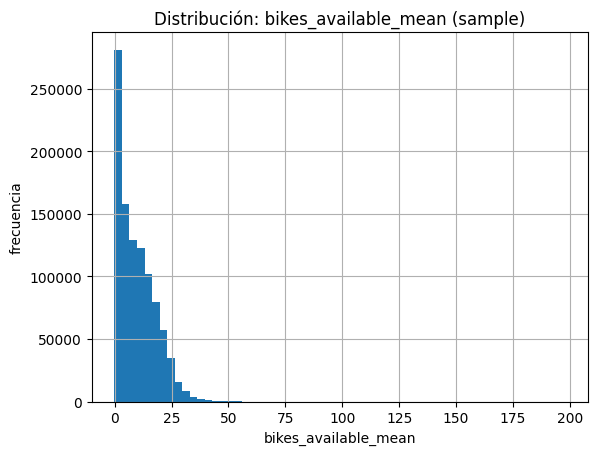

In [20]:
plt.figure()
df["bikes_available_mean"].dropna().hist(bins=60)
plt.title("Distribución: bikes_available_mean (sample)")
plt.xlabel("bikes_available_mean")
plt.ylabel("frecuencia")
plt.show()


In [23]:
print("value_counts is_holiday_new:")
print(df["is_holiday_new"].value_counts(dropna=False))

print("\nNum festivos en sample:", int((df["is_holiday_new"] == 1).sum()))


value_counts is_holiday_new:
is_holiday_new
0    1000000
Name: count, dtype: int64

Num festivos en sample: 0


In [24]:
holiday_cols = [c for c in df.columns if "holiday" in c.lower()]
print("holiday_cols =", holiday_cols)

for c in holiday_cols:
    s = pd.to_numeric(df[c], errors="coerce")
    print(c, "unique(non-null) =", sorted(s.dropna().unique())[:10], " ... total_unique=", s.dropna().nunique())


holiday_cols = ['is_holiday', 'is_holiday_new']
is_holiday unique(non-null) = [np.int8(0)]  ... total_unique= 1
is_holiday_new unique(non-null) = [np.int64(0)]  ... total_unique= 1


In [25]:
d0 = df.loc[df["is_holiday_new"] == 0, "bikes_available_mean"].dropna()
d1 = df.loc[df["is_holiday_new"] == 1, "bikes_available_mean"].dropna()

print("n no festivo:", len(d0), "| n festivo:", len(d1))

if len(d1) == 0:
    print("⚠️ En este sample no hay filas festivas. Genera otro sample (ver abajo).")
else:
    plt.figure()
    plt.boxplot([d0, d1], labels=["no festivo", "festivo"], showfliers=False)
    plt.title("Bikes disponibles: festivo vs no festivo")
    plt.ylabel("bikes_available_mean")
    plt.show()


n no festivo: 1000000 | n festivo: 0
⚠️ En este sample no hay filas festivas. Genera otro sample (ver abajo).


cmp sizes: is_holiday_new
0    200000
Name: count, dtype: int64


C:\Users\patxi\AppData\Local\Temp\ipykernel_15676\3088784834.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["no festivo", "festivo"], showfliers=False)


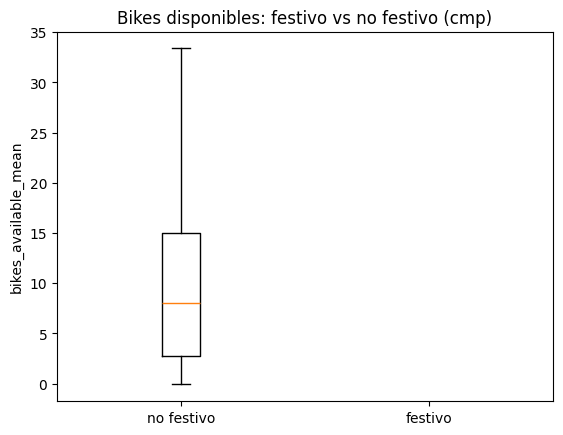

In [26]:
# Si en el sample no hay festivos, construimos un subset comparativo
df_h = df[df["is_holiday_new"] == 1]
df_n = df[df["is_holiday_new"] == 0].sample(n=min(len(df_h)*5, 200000), random_state=42) if len(df_h)>0 else df.sample(200000, random_state=42)

df_cmp = pd.concat([df_h, df_n], ignore_index=True)

print("cmp sizes:", df_cmp["is_holiday_new"].value_counts())

d0 = df_cmp.loc[df_cmp["is_holiday_new"] == 0, "bikes_available_mean"].dropna()
d1 = df_cmp.loc[df_cmp["is_holiday_new"] == 1, "bikes_available_mean"].dropna()

plt.figure()
plt.boxplot([d0, d1], labels=["no festivo", "festivo"], showfliers=False)
plt.title("Bikes disponibles: festivo vs no festivo (cmp)")
plt.ylabel("bikes_available_mean")
plt.show()


In [27]:
print([c for c in df.columns if "holiday" in c.lower()])
print(df["is_holiday_new"].value_counts(dropna=False))


['is_holiday', 'is_holiday_new']
is_holiday_new
0    1000000
Name: count, dtype: int64


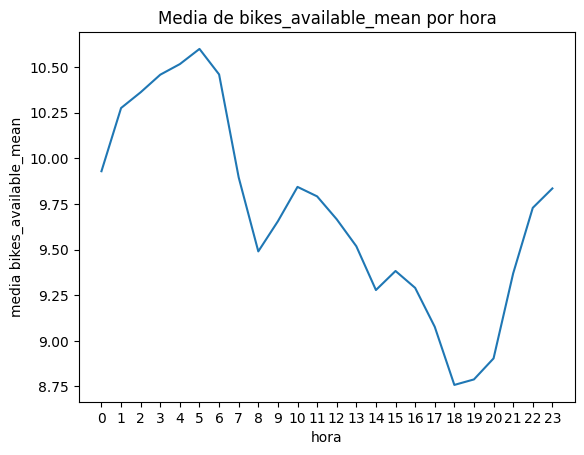

In [22]:
tmp = df.groupby("hour", as_index=False)["bikes_available_mean"].mean()

plt.figure()
plt.plot(tmp["hour"], tmp["bikes_available_mean"])
plt.title("Media de bikes_available_mean por hora")
plt.xlabel("hora")
plt.ylabel("media bikes_available_mean")
plt.xticks(range(0,24,1))
plt.show()


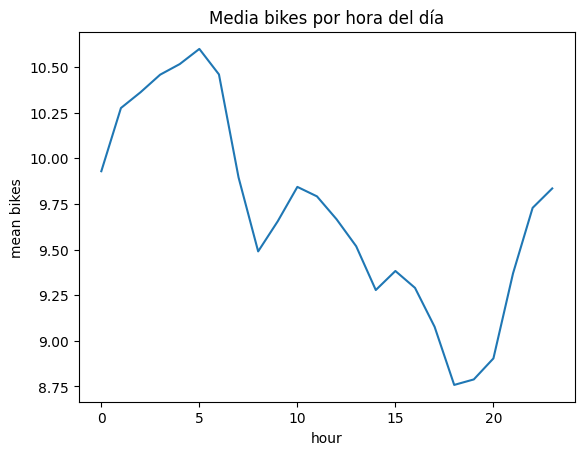

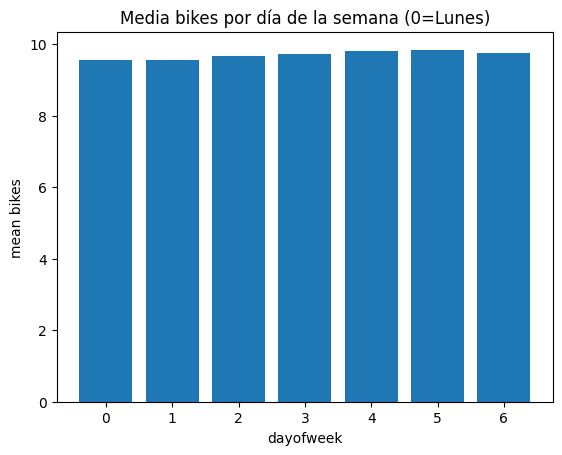

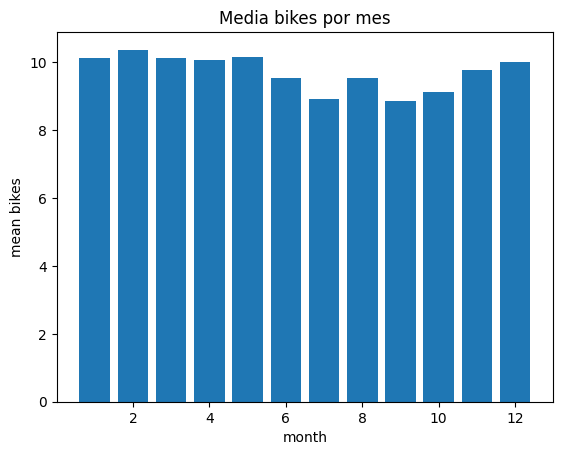

In [10]:
g_hour = df.groupby("hour", as_index=False)["bikes_available_mean"].mean()

plt.figure()
plt.plot(g_hour["hour"], g_hour["bikes_available_mean"])
plt.title("Media bikes por hora del día")
plt.xlabel("hour")
plt.ylabel("mean bikes")
plt.show()

g_dow = df.groupby("dayofweek", as_index=False)["bikes_available_mean"].mean()

plt.figure()
plt.bar(g_dow["dayofweek"], g_dow["bikes_available_mean"])
plt.title("Media bikes por día de la semana (0=Lunes)")
plt.xlabel("dayofweek")
plt.ylabel("mean bikes")
plt.show()

g_month = df.groupby("month", as_index=False)["bikes_available_mean"].mean()

plt.figure()
plt.bar(g_month["month"], g_month["bikes_available_mean"])
plt.title("Media bikes por mes")
plt.xlabel("month")
plt.ylabel("mean bikes")
plt.show()


In [12]:
# --- Compatibilidad columnas festivos ---
print("Columnas festivos disponibles:",
      [c for c in df.columns if "holiday" in c.lower()])

if "is_holiday_new" not in df.columns:
    if "is_holiday_bcn" in df.columns:
        df["is_holiday_new"] = df["is_holiday_bcn"]
        print("✅ is_holiday_new <- is_holiday_bcn")
    elif "is_holiday" in df.columns:
        df["is_holiday_new"] = df["is_holiday"]
        print("✅ is_holiday_new <- is_holiday")
    else:
        raise KeyError("No encuentro ninguna columna de festivos (is_holiday_bcn / is_holiday)")


Columnas festivos disponibles: ['is_holiday']
✅ is_holiday_new <- is_holiday


Usando holiday_col = is_holiday


C:\Users\patxi\AppData\Local\Temp\ipykernel_15676\1454294091.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0.sample(min(len(d0), 50000), random_state=42),


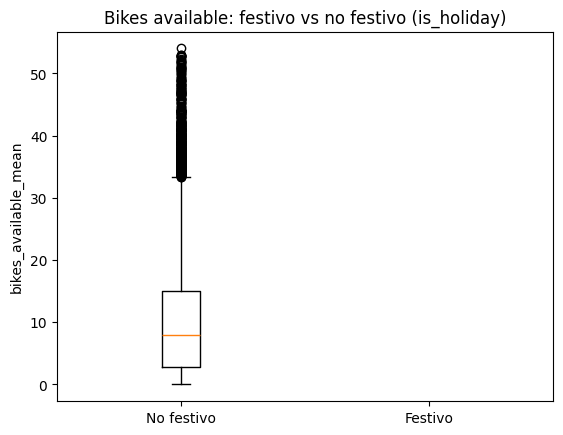

In [14]:
holiday_col = "is_holiday_bcn" if "is_holiday_bcn" in df.columns else "is_holiday"
print("Usando holiday_col =", holiday_col)

d0 = df[df[holiday_col] == 0]["bikes_available_mean"].dropna()
d1 = df[df[holiday_col] == 1]["bikes_available_mean"].dropna()

plt.figure()
plt.boxplot([d0.sample(min(len(d0), 50000), random_state=42),
             d1.sample(min(len(d1), 50000), random_state=42)],
            labels=["No festivo", "Festivo"])
plt.title(f"Bikes available: festivo vs no festivo ({holiday_col})")
plt.ylabel("bikes_available_mean")
plt.show()


⚠️ Falta columna: is_holiday_barcelona
⚠️ Falta columna: is_holiday_catalunya
⚠️ Falta columna: is_holiday_spain


C:\Users\patxi\AppData\Local\Temp\ipykernel_15676\1632227434.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0.sample(min(len(d0), 50000), random_state=1), d1.sample(min(len(d1), 50000), random_state=1)], labels=["No holiday", "Holiday"])


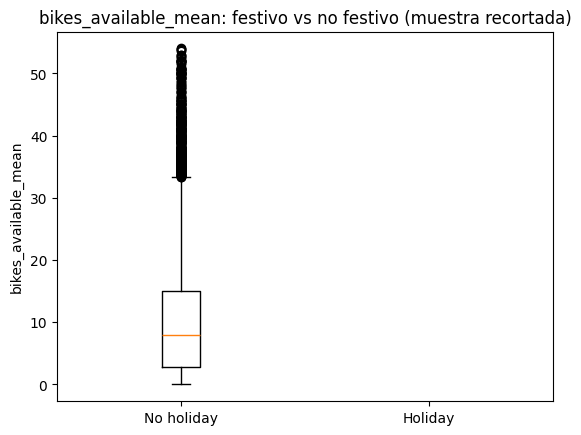

KeyError: 'is_holiday_barcelona'

In [15]:
# Columnas que añadiste con el script:
# is_holiday_new, is_holiday_barcelona, is_holiday_catalunya, is_holiday_spain

for c in ["is_holiday_new", "is_holiday_barcelona", "is_holiday_catalunya", "is_holiday_spain"]:
    if c not in df.columns:
        print("⚠️ Falta columna:", c)

# Boxplot Holiday vs No holiday (general)
d0 = df[df["is_holiday_new"] == 0]["bikes_available_mean"].dropna()
d1 = df[df["is_holiday_new"] == 1]["bikes_available_mean"].dropna()

plt.figure()
plt.boxplot([d0.sample(min(len(d0), 50000), random_state=1), d1.sample(min(len(d1), 50000), random_state=1)], labels=["No holiday", "Holiday"])
plt.title("bikes_available_mean: festivo vs no festivo (muestra recortada)")
plt.ylabel("bikes_available_mean")
plt.show()

# Medias por tipo
types = {
    "holiday_any": "is_holiday_new",
    "holiday_bcn": "is_holiday_barcelona",
    "holiday_cat": "is_holiday_catalunya",
    "holiday_spain": "is_holiday_spain",
}

rows = []
for k, col in types.items():
    rows.append({
        "flag": k,
        "mean_bikes_when_1": df.loc[df[col] == 1, "bikes_available_mean"].mean(),
        "mean_bikes_when_0": df.loc[df[col] == 0, "bikes_available_mean"].mean(),
        "pct_1": (df[col].mean() * 100.0)
    })

pd.DataFrame(rows).sort_values("pct_1", ascending=False)


In [16]:
print([c for c in df.columns if "holiday" in c.lower()])


['is_holiday', 'is_holiday_new']
